In [53]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

**Import pickeled data file with 4hr interval entries and exits per turnstile**

In [97]:
with open('weighted_4hr_interval_mta.pickle','rb') as read_file:
    time_series_df = pickle.load(read_file)

In [98]:
time_series_df.shape

(2519821, 17)

In [99]:
time_series_df.head()

C/A  UNIT       SCP STATION LINENAME    ENTRIES      EXITS  \
0  A002  R051  02-00-00   59 ST  NQR456W  6566470.0  2224053.0   
1  A002  R051  02-00-00   59 ST  NQR456W  6566470.0  2224053.0   
2  A002  R051  02-00-00   59 ST  NQR456W  6566470.0  2224055.0   
3  A002  R051  02-00-00   59 ST  NQR456W  6566470.0  2224055.0   
4  A002  R051  02-00-00   59 ST  NQR456W  6566470.0  2224055.0   

            DATE_TIME        DATE     DESC TIME_INTERVAL  ENTRY_DIFF  \
0 2018-03-31 03:59:00  2018-03-31  REGULAR      04:00:00    0.026906   
1 2018-03-31 07:59:00  2018-03-31  REGULAR      04:00:00    0.000000   
2 2018-03-31 11:59:00  2018-03-31  REGULAR      04:00:00    0.000000   
3 2018-03-31 15:59:00  2018-03-31  REGULAR      04:00:00    0.000000   
4 2018-03-31 19:59:00  2018-03-31  REGULAR      04:00:00    0.000000   

   EXIT_DIFF        LAT        LONG ZIPCODE    WEIGHT  
0   0.011531  40.762796  -73.967686   10022  0.003844  
1   0.000000  40.762796  -73.967686   10022  0.003844  
2   0.007688  40.762796  -73.967686   10022  0.003844  
3   0.000000  40.762796  -73.967686   10022  0.003844  
4   0.000000  40.762796  -73.967686   10022  0.003844

**ENTRIES per day at each subway station/line combination**

In [122]:
grouping = ['STATION','LINENAME','DATE']

In [123]:
daily_entries_per_station_line = time_series_df.groupby(by=grouping)['ENTRY_DIFF'].sum().reset_index()

In [124]:
daily_entries_per_station_line.shape

(42953, 4)

In [125]:
daily_entries_per_station_line['ENTRY_DIFF'].max()

2085.2342869440004

In [126]:
zero_mask_entries = (daily_entries_per_station_line.ENTRY_DIFF == 0)
daily_entries_per_station_line[zero_mask_entries].shape[0]

2808

In [127]:
daily_entries_per_station_line.head()

STATION LINENAME        DATE  ENTRY_DIFF
0    1 AV        L  2018-03-31  177.360380
1    1 AV        L  2018-04-01  129.434702
2    1 AV        L  2018-04-02  197.394620
3    1 AV        L  2018-04-03  212.583769
4    1 AV        L  2018-04-04  221.287784

**EXITS per day at each subway station/line combination**

In [128]:
daily_exits_per_station_line = time_series_df.groupby(by=grouping)['EXIT_DIFF'].sum().reset_index()

In [129]:
daily_exits_per_station_line.shape

(42953, 4)

In [130]:
daily_exits_per_station_line['EXIT_DIFF'].max()

942.3974629299997

In [131]:
zero_mask_exits = (daily_exits_per_station_line.EXIT_DIFF == 0)
daily_exits_per_station_line[zero_mask_exits].shape[0]

2851

In [132]:
daily_exits_per_station_line.head()

STATION LINENAME        DATE   EXIT_DIFF
0    1 AV        L  2018-03-31  193.900151
1    1 AV        L  2018-04-01  149.479662
2    1 AV        L  2018-04-02  211.254585
3    1 AV        L  2018-04-03  241.536410
4    1 AV        L  2018-04-04  238.824444

**Merge daily entries and exits by station-line into a single data file**

In [133]:
daily_station_line_counts = pd.merge(daily_entries_per_station_line, daily_exits_per_station_line, on=['STATION', 'LINENAME', 'DATE'])

In [134]:
daily_station_line_counts.head()

STATION LINENAME        DATE  ENTRY_DIFF   EXIT_DIFF
0    1 AV        L  2018-03-31  177.360380  193.900151
1    1 AV        L  2018-04-01  129.434702  149.479662
2    1 AV        L  2018-04-02  197.394620  211.254585
3    1 AV        L  2018-04-03  212.583769  241.536410
4    1 AV        L  2018-04-04  221.287784  238.824444

In [135]:
daily_station_line_counts.shape

(42953, 5)

**Remove days with zero ENTRIES or EXITS from the dataset. Assumption: subway stations that had 0 entries or exits for a full 24 hours are incorrect data or were closed, so removed**

In [136]:
daily_station_line_counts= daily_station_line_counts[daily_station_line_counts.ENTRY_DIFF != 0]

In [137]:
daily_station_line_counts= daily_station_line_counts[daily_station_line_counts.EXIT_DIFF != 0]

In [138]:
daily_station_line_counts.shape

(39987, 5)

**Get summed daily entries and exits for each day, by Station and Line**

In [139]:
daily_station_line_counts['DAILY_TOTAL'] = daily_station_line_counts['ENTRY_DIFF'] + daily_station_line_counts['EXIT_DIFF']

In [140]:
daily_station_line_counts.head()

STATION LINENAME        DATE  ENTRY_DIFF   EXIT_DIFF  DAILY_TOTAL
0    1 AV        L  2018-03-31  177.360380  193.900151   371.260531
1    1 AV        L  2018-04-01  129.434702  149.479662   278.914365
2    1 AV        L  2018-04-02  197.394620  211.254585   408.649205
3    1 AV        L  2018-04-03  212.583769  241.536410   454.120179
4    1 AV        L  2018-04-04  221.287784  238.824444   460.112229

In [141]:
daily_station_line_counts['DAILY_TOTAL'].max()

2583.8911036040004

**Save the daily totals by station-line file**

In [142]:
with open('daily_weighted_station_line_counts.pickle', 'wb') as to_write:
    pickle.dump(daily_station_line_counts, to_write)

In [143]:
with open('daily_weighted_station_line_counts.pickle','rb') as read_file:
    daily_station_line_counts = pickle.load(read_file)

In [144]:
daily_station_line_counts.head()

STATION LINENAME        DATE  ENTRY_DIFF   EXIT_DIFF  DAILY_TOTAL
0    1 AV        L  2018-03-31  177.360380  193.900151   371.260531
1    1 AV        L  2018-04-01  129.434702  149.479662   278.914365
2    1 AV        L  2018-04-02  197.394620  211.254585   408.649205
3    1 AV        L  2018-04-03  212.583769  241.536410   454.120179
4    1 AV        L  2018-04-04  221.287784  238.824444   460.112229

**Get total counts per station-line - over the entire season of April/May/June**

In [145]:
total_spring_station_line_counts = daily_station_line_counts.groupby(by=['STATION', 'LINENAME'])['DAILY_TOTAL'].sum().reset_index()

In [146]:
total_spring_station_line_counts.rename(columns={'DAILY_TOTAL': 'SPRING_TOTAL'}, inplace=True)

In [147]:
total_spring_station_line_counts.sort_values(by="SPRING_TOTAL", ascending=False).head(10)

STATION  LINENAME   SPRING_TOTAL
28    14 ST-UNION SQ  LNQR456W  112740.091413
89   34 ST-HERALD SQ  BDFMNQRW  106947.123498
91    34 ST-PENN STA       ACE   83945.999421
319  JAY ST-METROTEC       ACF   77034.334487
198       BEDFORD AV         L   71651.720065
207     BOROUGH HALL     2345R   71296.330515
123   59 ST COLUMBUS     ABCD1   65365.271967
159            96 ST       123   59428.275745
27    14 ST-UNION SQ  456LNQRW   48753.182202
433   W 4 ST-WASH SQ   ABCDEFM   47261.987540

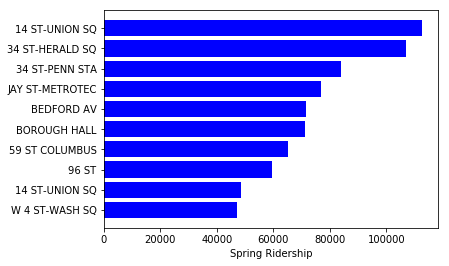

In [150]:
spring_riders = total_spring_station_line_counts.sort_values(by="SPRING_TOTAL", ascending=False).head(10)

fig, ax = plt.subplots()

stations = spring_riders.STATION
y_pos = np.arange(len(stations))
riders = spring_riders.SPRING_TOTAL

ax.barh(y_pos, riders, align='center',
        color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(stations)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Spring Ridership')

plt.show()

In [173]:
daily_station_line_counts.columns

Index(['STATION', 'LINENAME', 'DATE', 'ENTRY_DIFF', 'EXIT_DIFF',
       'DAILY_TOTAL'],
      dtype='object')

In [186]:
mean_daily = daily_station_line_counts.groupby(by='DATE')['DAILY_TOTAL'].sum().reset_index()

Text(0.5,0,'Date')

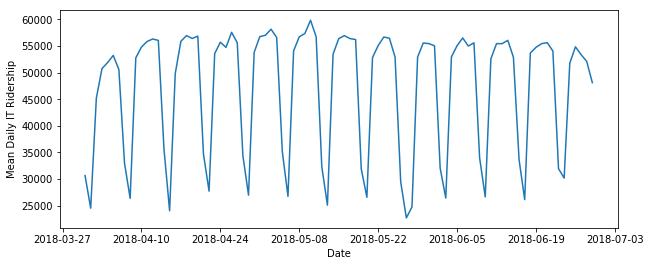

In [187]:
x = mean_daily.DATE
y = mean_daily.DAILY_TOTAL
fig=plt.figure(figsize=(10,4))
plt.plot(x,y)
plt.ylabel('Mean Daily IT Ridership')
plt.xlabel('Date')